# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

This data represents 17 campaigns with 79354 contacts gathered. The campaigns were all phone campaigns conducted between May 2008 and November 2010.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [4]:
import pandas as pd
import numpy as np
import time

# data viz
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight") # styling your charts

# pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


# modeling
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

# validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

print("All modules loaded")

All modules loaded


In [5]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [6]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [7]:
df.shape

(41188, 21)

In [8]:
#y Values are not balanced:
df.y.value_counts(normalize=True).round(2)

y
no     0.89
yes    0.11
Name: proportion, dtype: float64

In [9]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

Let's explore the data distribution

In [10]:
df['housing'].value_counts()

housing
yes        21576
no         18622
unknown      990
Name: count, dtype: int64

In [11]:
df['loan'].value_counts()

loan
no         33950
yes         6248
unknown      990
Name: count, dtype: int64

In [12]:
df['month'].value_counts()

month
may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: count, dtype: int64

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

We have 20 features plus the outcome 'y': half of them are numerical and half are not

In [15]:
# check for duplicated column names
df.columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [16]:
# Let's get rid of the duplicates now
df.duplicated().sum()

12

In [17]:
df = df.drop_duplicates()

In [13]:
df.dropna()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [18]:
# Let's check for N/A values:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [19]:
# percentage of missing values
df.isna().mean().sort_values()

age               0.0
euribor3m         0.0
cons.conf.idx     0.0
cons.price.idx    0.0
emp.var.rate      0.0
poutcome          0.0
previous          0.0
pdays             0.0
campaign          0.0
nr.employed       0.0
duration          0.0
month             0.0
contact           0.0
loan              0.0
housing           0.0
default           0.0
education         0.0
marital           0.0
job               0.0
day_of_week       0.0
y                 0.0
dtype: float64

In [21]:
# This is an unbalanced Dataset for the outcome:
df['y'].value_counts()


y
no     36537
yes     4639
Name: count, dtype: int64

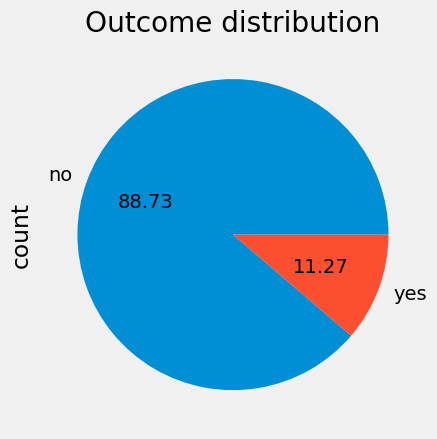

In [22]:
# Is More clear with a chart:
df['y'].value_counts().plot.pie(autopct="%.2f", title="Outcome distribution");


In [23]:
# Let's convert the y into numerical
df['y'] = df['y'].replace({"yes":1, "no" :0})

Now we vidualize some non numerical features against the outcome 'y' to see if we can find any particular correlation useful to the feature engineering we will perform in the next steps

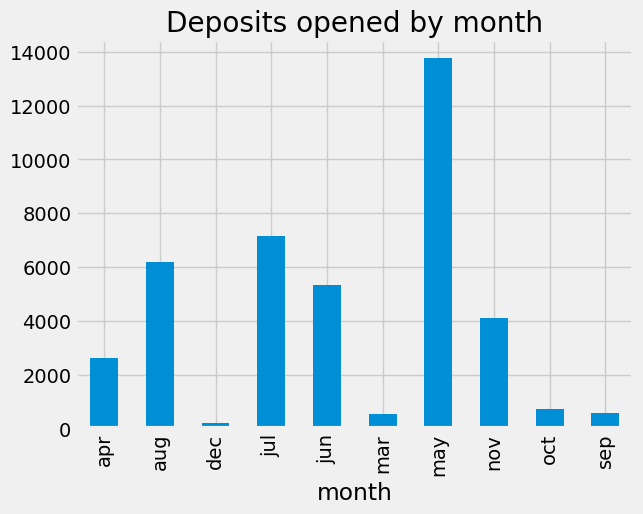

In [24]:
# Let's explore the data to understand them better
df.groupby('month')['y'].count().plot(kind = 'bar', title='Deposits opened by month');

Deposits are opened in May and july mostly, no specific distribution can be inferred

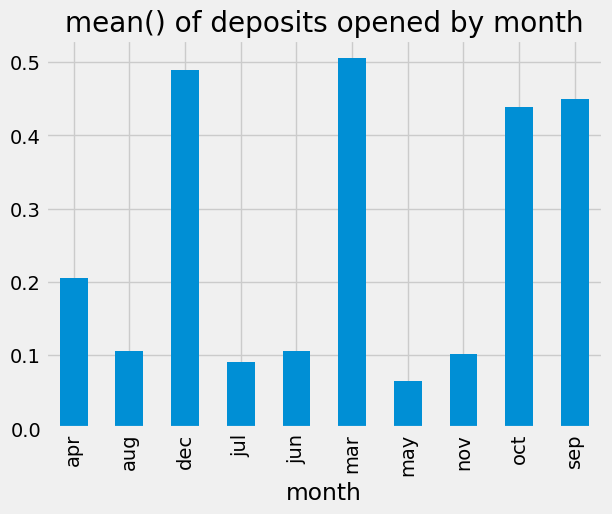

In [62]:
df.groupby('month')['y'].mean().plot(kind = 'bar', title='mean() of deposits opened by month');

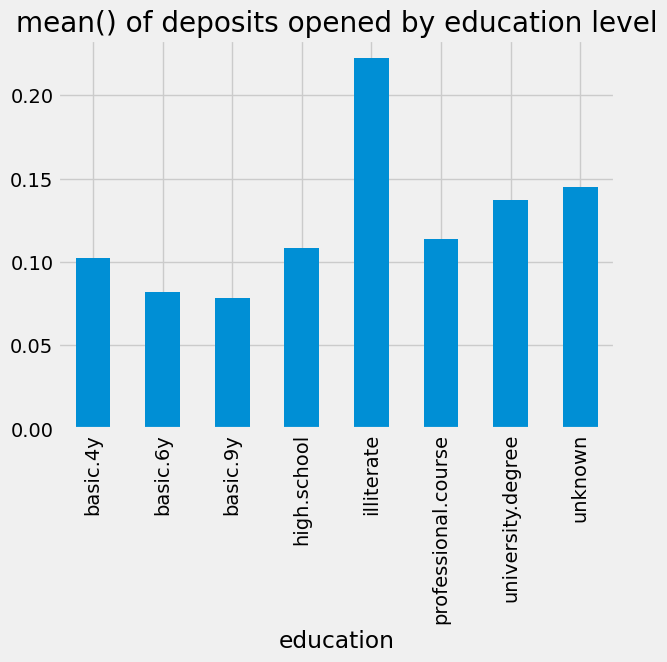

In [26]:
# Mean of deposits opened by education level
df.groupby('education')['y'].mean().plot(kind = 'bar', title="mean() of deposits opened by education level");


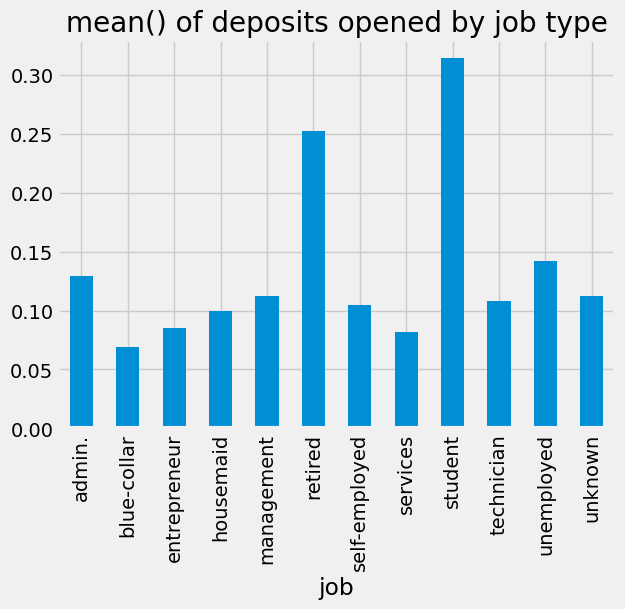

In [27]:
#It does not look like there is much correlation here
df.groupby('job')['y'].mean().plot(kind = 'bar', title="mean() of deposits opened by job type");

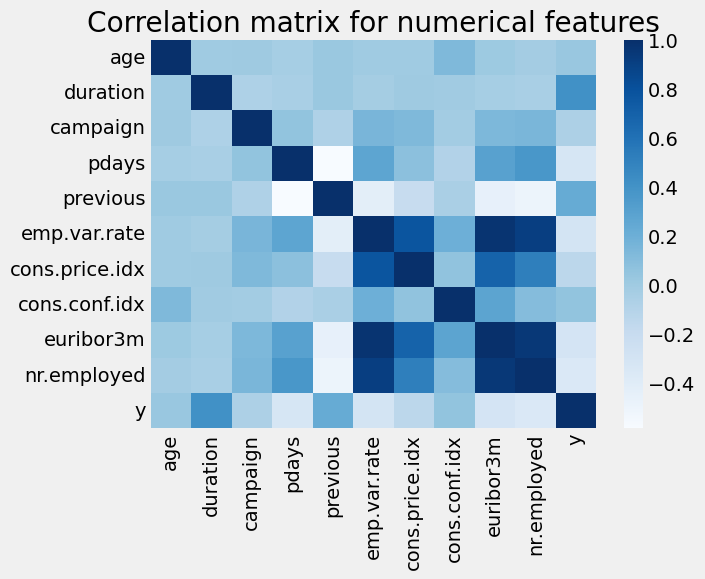

In [28]:
# Correlation Matrix
corr = df.corr(numeric_only=True).round(3)
ax = plt.axes()
sns.heatmap(corr, ax = ax, cmap="Blues")
ax.set_title('Correlation matrix for numerical features')
plt.show()

It does not look like there is a lot of correlation we can leverage, although what we can highlight is correlation between these two features:

*   emp.var.rate
*   cons.price.idx

and these two as well:

*   euribor3m
*   nr.employed

Also, the only correlation of the outcome y and the features is 'duration' and 'previous' both related to being previously contacted by marketing



### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

Bank information features are the following:

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

In [29]:
# We create a new datafram with justthese features
bank_df=df[['age','job','marital','education','default','housing', 'loan','y']]

In [30]:
bank_df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'y'],
      dtype='object')

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [31]:
# Let's build the model now
X = bank_df.drop(columns = 'y')
y = bank_df['y']
X.head()

,age,job,marital,education,default,housing,loan
0,56,housemaid,married,basic.4y,no,no,no
1,57,services,married,high.school,unknown,no,no
2,37,services,married,high.school,no,yes,no
3,40,admin.,married,basic.6y,no,no,no
4,56,services,married,high.school,no,no,yes


In [32]:
#One Hot Encoder
enc = OneHotEncoder(drop = 'if_binary', handle_unknown='ignore', sparse=False)
enc.fit(X)
X_enc = enc.transform(X)
one_hot_encoder_features = enc.get_feature_names_out()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size = 0.20, random_state = 42, stratify = y)
print(X_train.shape)
print(y_train.shape)

print(y_test.shape)
print(X_test.shape)
X_train

(32940, 111)
(32940,)
(8236,)
(8236, 111)


array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [34]:
# Encode the label
encoder = LabelEncoder()

# modify the train
y_train = encoder.fit_transform(y_train)

# modify the test
y_test = encoder.transform(y_test)

In [35]:
# Scale numbers
scaler = StandardScaler()

# train data
X_train_scaled = scaler.fit_transform(X_train)

# test data
X_test_scaled = scaler.transform(X_test)

In [36]:
#Convert to Pandas df from numpy array
X_train_scaled = pd.DataFrame(X_train_scaled, columns = one_hot_encoder_features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = one_hot_encoder_features)


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [37]:
# DUMMY CLASSIFIER
dummy = DummyClassifier(strategy= "prior")
# fit the mdel
dummy.fit(X_train_scaled, y_train)
# accuracy score
print("The accuracy of the dummy classifier for train is {:.2%}".format(dummy.score(X_train_scaled, y_train)))
print("The accuracy of the dummy classifier for test is {:.2%}".format(dummy.score(X_test_scaled, y_test)))

The accuracy of the dummy classifier for train is 88.73%
The accuracy of the dummy classifier for test is 88.73%


In [38]:
predict_dummy = dummy.predict(X_test_scaled)
print(classification_report(y_test, predict_dummy))


              precision    recall  f1-score   support

           0       0.89      1.00      0.94      7308
           1       0.00      0.00      0.00       928

    accuracy                           0.89      8236
   macro avg       0.44      0.50      0.47      8236
weighted avg       0.79      0.89      0.83      8236



### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [39]:
logistic = LogisticRegression()
logistic.fit(X_train_scaled, y_train)

LogisticRegression()

### Problem 9: Score the Model

What is the accuracy of your model?

In [40]:
predict_logisic = logistic.predict(X_test_scaled)
print(classification_report(y_test, predict_logisic))


              precision    recall  f1-score   support

           0       0.89      1.00      0.94      7308
           1       0.44      0.02      0.05       928

    accuracy                           0.89      8236
   macro avg       0.67      0.51      0.49      8236
weighted avg       0.84      0.89      0.84      8236



### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [41]:
# Comparing Models: define helper lists
models_list = [DecisionTreeClassifier(), LogisticRegression(), KNeighborsClassifier(), SVC()]
time_to_train = []
accuracy = []
train_accuracy = []

In [42]:
#Test Data accuracy scores for scaled data

for model in models_list:

    # Fit the model
    t0 = time.time()
    print(model)
    model.fit(X_train_scaled, y_train)
    print('\n')
    t1 = time.time()

    # Prediction score for test and train
    predictions = model.predict(X_test_scaled)
    train_predictions = model.predict(X_train_scaled)
    model_accuracy = accuracy_score(predictions, y_test)
    model_train_accuracy = accuracy_score(train_predictions, y_train)

    print(f'accuracy score: {model_accuracy}')
    print(f'train accuracy score: {model_train_accuracy}')
    dt = t1-t0
    print(f'time to train: {dt:.2f}')
    print('\n')

    # print classification report
    print(classification_report(y_test, predictions))
    time_to_train.append(dt)
    accuracy.append(model_accuracy)
    train_accuracy.append(model_train_accuracy)
    print('\n')



DecisionTreeClassifier()


accuracy score: 0.8669256920835356
train accuracy score: 0.9176077717061324
time to train: 0.59


              precision    recall  f1-score   support

           0       0.89      0.97      0.93      7308
           1       0.24      0.09      0.13       928

    accuracy                           0.87      8236
   macro avg       0.57      0.53      0.53      8236
weighted avg       0.82      0.87      0.84      8236



LogisticRegression()


accuracy score: 0.8865954346770277
train accuracy score: 0.8880388585306618
time to train: 0.26


              precision    recall  f1-score   support

           0       0.89      1.00      0.94      7308
           1       0.44      0.02      0.05       928

    accuracy                           0.89      8236
   macro avg       0.67      0.51      0.49      8236
weighted avg       0.84      0.89      0.84      8236



KNeighborsClassifier()


accuracy score: 0.8757892180670228
train accuracy score: 0.890892531876

In [43]:
results = pd.DataFrame({
  'Model': models_list,
  'Test Accuracy': accuracy,
  'Train Accuracy': train_accuracy,
  'Time to Train (s)': time_to_train,
  })

print(results)

                      Model  Test Accuracy  Train Accuracy  Time to Train (s)
0  DecisionTreeClassifier()       0.866926        0.917608           0.590077
1      LogisticRegression()       0.886595        0.888039           0.257713
2    KNeighborsClassifier()       0.875789        0.890893           0.010759
3                     SVC()       0.884896        0.890710         245.927728


The accuracy for all four tests is similar, with Logistic regression being the best with SVM runner up.

Notable the amount of time taken by SVM due to conmplex matric calculations part of the training process

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

The code below tries to do a GridSearcCV with different kernels.

Given the 111 features introduced by the OneHot Encoding and working with a CPU, the cross validation times out for KNN and SVM


In [46]:
# Let's try to optimize Logistic Regression
parameters = [{'penalty':['l1','l2']},
              {'C':[1, 10, 100, 1000]}]
grid_search_LR = GridSearchCV(estimator = LogisticRegression(),
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)

# fit the model on train data
grid_result_LR = grid_search_LR.fit(X_train_scaled, y_train)



In [59]:
# Let's see the best parameters as identified by cross validation
print(grid_result_LR.best_params_)
print(grid_result_LR.best_score_)

{'penalty': 'l2'}
0.8860959319975713


In [48]:
# summarize results (future use)
grid_result_LR_summary = pd.DataFrame(grid_result_LR.cv_results_)

In [49]:
grid_predictions_LR = grid_result_LR.predict(X_test_scaled)
# print classification report
print(classification_report(y_test, grid_predictions_LR))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      7308
           1       0.44      0.02      0.05       928

    accuracy                           0.89      8236
   macro avg       0.67      0.51      0.49      8236
weighted avg       0.84      0.89      0.84      8236



In [54]:
# Trying Decision tree and GridCV
param_dict = {"criterion":['gini', 'entropy'], "max_depth":range(1,10), "min_samples_split":range(1,10), "min_samples_leaf":range(1,5)}
grid_search_DT = GridSearchCV(estimator = DecisionTreeClassifier(),
                           param_grid = param_dict,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)

# fit the model on train data
grid_result_DT = grid_search_DT.fit(X_train_scaled, y_train)
# summarize results
grid_result_DT_summary = pd.DataFrame(grid_result_DT.cv_results_)

In [61]:
# Let's see the best parameters as identified by cross validation
print(grid_result_DT.best_params_)
print(grid_result_DT.best_score_)


{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.8874013357619915


In [56]:
grid_predictions_DT = grid_result_DT.predict(X_test_scaled)
# print classification report
print(classification_report(y_test, grid_predictions_DT))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      7308
           1       0.30      0.01      0.01       928

    accuracy                           0.89      8236
   macro avg       0.60      0.50      0.48      8236
weighted avg       0.82      0.89      0.84      8236



In [ ]:
# Let's try with KNN
cv_method = RepeatedStratifiedKFold(n_splits=5,
                                    n_repeats=3,
                                    random_state=42)


# Define our candidate hyperparameters
hp_candidates = [{'n_neighbors': [2,8,10], 'weights': ['uniform','distance'],'p':[1,2,5]}]

# Search for best hyperparameters
grid = GridSearchCV(estimator=KNeighborsClassifier(),
                      param_grid=hp_candidates,
                      cv=cv_method,
                      verbose=1,
                      scoring='accuracy',
                      return_train_score=True)

grid_resultKNN = grid.fit(X_train_scaled,y_train)
# summarize results
grid_result_KNN_Summary = pd.DataFrame(grid_resultKNN.cv_results_)
grid_resultKNN.best_score_

In [ ]:
# Let's try to optimize SVM:
kernel_range = ['linear', 'poly', 'rbf', 'sigmoid']
C_range = range(1, 10, 2)
degree_range = range(1, 5)
max_iter_range = [-1, 1, 2]

# putting it togther
grid = dict(kernel = kernel_range, C = C_range, degree = degree_range, max_iter = max_iter_range)
print(grid)
grid_search_SVM = GridSearchCV(estimator = SVC()
                           ,param_grid = grid
                           ,n_jobs = -1
                           ,cv = 3
                           ,scoring ='accuracy')

# fit the model on train data
grid_result_SVM = grid_search_SVM.fit(X_train_scaled, y_train)

# summarize results
grid_result_SVM = pd.DataFrame(grid_result.cv_results_)
grid_result.best_estimator_

Results for Logistic Regression and Decision Tree after the GridSearch cross validation are in line with what we found using the default parameters, while we were unable to run cross validation with KNN and SVM due to computational contraints


**Conclusions**

The classification model generated has accuracies and f1-score around 88% and up which means it does a good job to predict customer opening an account: domain knowledge shows that marital status, having a mortgage or a personal loan are strong indicators of accepting bank opening account offers and contributed to get the prediction right.

LogisticRegression() along with GridSearchCV helped achieve accuracy on test data of 89% and f1-score of 94%, making it the classifier of choice with the compute resources available.

Being able to access to powerful GPUs would have helped with cross validation for KNN and SVM, possibly scoring even better accuracy with fine tuned models.

**Possible Next Steps **

Including the 'number of contacts performed before this campaign and for this client' as feature ('previous') and its outcome (feature 'poutcome') might improve further the accuracy of the prediction and should be tested as next step.

Lastly, It would be interesting to explore accuracy of the model only using numerical features as we only used the bank data that were mostly non numerical: likely not a game changer as we noticed from the correlation matrix posted above, but still interesting to take a look at it.